In [46]:
import numpy as np 
import xarray as xr 
import scipy 
import matplotlib.pyplot as plt  # Plotting library
import cartopy, cartopy.crs as ccrs  # Plot maps
import random 
import satcmaps as cmaps
import image_retrieval as img
import goesRequest2 as goes 
from recenterIR import recenter_ir

In [47]:
def calculate_degrees(dataset): # Adapted from https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset['x']  # E/W scanning angle in radians
    y_coordinate_1d = dataset['y']  # N/S elevation angle in radians
    projection_info = dataset['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon


In [48]:
def Gradient2D(arr, lats, lons):
    if lats.ndim == 2:
        lats = lats[:, 0]
    if lons.ndim == 2:
        lons = lons[0, :]

    dA_dlon, dA_dlat = np.gradient(arr, lats, lons, axis=(1,0))
    return dA_dlon, dA_dlat

In [49]:
def reproject(dataset, lats, lons, pos):   
    size = 3.6
    IR = dataset['CMI'].data - 273.15
                        
    # Extents and interpolation for IR
    minimglat = pos[0] - size
    maximglat = pos[0] + size
    minimglon = pos[1] - size
    maximglon = pos[1] + size
    res = 0.0179985     # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))
    
    lats = lats.flatten()
    lons = lons.flatten()
    IR = IR.flatten()
    
    # Fix shape issue for boolean conditions
    floater_IR = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
                    np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    gridded_data = scipy.interpolate.griddata((lats[floater_IR], lons[floater_IR]), IR[floater_IR], (grid[0], grid[1]), method='linear')
    
    return grid[1], grid[0], gridded_data

In [50]:
def stormir(lons, lats, data, pos, time, cmap = 'irg'):
    try:
        lat, lon = pos
        extent = [lon - 1, lon + 1, lat - 1, lat + 1]
        figSize = (18, 9)
    except:
        extent, figSize = REGIONS[pos.upper()]
        lon = (extent[0] + extent[1]) / 2

    try:
        if pos.lower() in ['spac', 'scpac', 'enso']:
            goes.makeMap(extent, figSize, 180)
    except:
        goes.makeMap(extent, figSize) 
    
    if cmap.lower() == 'random':
        rand = random.randrange(0, len(cmaps.irtables.keys()), 1)
        cmap = list(cmaps.irtables.keys())[rand]
        
    cmap, vmax, vmin = cmaps.irtables[cmap.lower()]

    plt.pcolormesh(lons, lats, data, vmin = vmin, vmax = vmax, cmap = cmap)
    plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {time}' , fontweight='bold', fontsize=10, loc='left')
    plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
    plt.savefig(r"C:\Users\deela\Downloads\stormir.png", dpi = 250, bbox_inches = 'tight')
    plt.show()
    plt.close()
    #data[0].close()

In [51]:
def rePoPolar(dataset, lats, lons, center = None):
    if center is None:
        clat = np.nanmean(lats)
        clon = np.nanmean(lons)
    else:
        clat, clon = center
    print(clat, clon)

    R = 6371.0
    cphi = np.cos(np.radians(clat))
    x = R * np.radians(lons - clon) * cphi
    y = R * np.radians(lats - clat)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(0, 500, 500)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 200)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            'data': (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    polar = polar.sel(r = slice(0, 500))
    polar = polar.interp(r = np.arange(0, 500, 1))

    return x, y, polar['data']


In [ ]:
def run(data, polar, xkm, ykm):
    from scipy.ndimage import gaussian_filter1d

    ir_std = np.nanstd(polar.values, axis = 1)
    ir_std = gaussian_filter1d(ir_std, sigma = 6)
    ir_azi = np.nanmax(polar.values, axis = 1)
    radii = polar.r.values

    diff = (np.diff(ir_std) / np.diff(radii))
    diff2_std = np.diff(diff) / np.diff(radii[1:])
    diff2 = np.diff(ir_azi) / np.diff(radii)
    diff2 = gaussian_filter1d(diff2, sigma = 2)

    min_ir_rad, min_ir_radARG = radii[np.nanargmin(ir_azi)], np.nanargmin(ir_azi)
    min_ir_temp = np.nanmin(ir_azi)
    eyerad, eyeradARG = radii[np.nanargmin(diff2[:np.nanargmin(ir_azi)])], np.nanargmin(diff2[:np.nanargmin(ir_azi)]) 
    eyetemp = np.nanmax(ir_azi[radii < min_ir_rad])
    icdoedge, icdoedgeARG = (eyerad + min_ir_rad) / 2, int((eyeradARG + min_ir_radARG) / 2)
    tempArray = np.arange(0, 499, dtype = 'float32')

    temp = int(min_ir_radARG)
    thresh = 
    zeroPoint = temp + np.where((ir_azi[temp:] > -5) & (ir_azi[temp:] < 5))[0][0]
    print(zeroPoint)

    tempArray[0:temp] = np.nan
    tempArray[temp:] = diff[temp:]
    tempArray[zeroPoint:] = np.nan
    ocdoedge, ocdoedgeARG = radii[np.nanargmax(tempArray)], np.nanargmax(tempArray)

    # candidates = temp + np.where((diff2_std[temp:temp+100] > -0.001) & (diff2_std[temp:temp+100] < 0.001))[0]
    # candidates = np.append(candidates, ocdoedge)
    # print(candidates, np.nanmean(candidates), np.nanmedian(candidates))
    # ocdoedge, ocdoedgeARG = np.nanmax([radii[int(np.nanmean(candidates))], radii[int(np.nanmedian(candidates))]]), np.nanmax([int(np.nanmean(candidates)), int(np.nanmedian(candidates))])
    
    cdostd = np.nanmean(ir_std[icdoedgeARG:int(ocdoedgeARG)])
    print('CDO STD:', 1 / cdostd, cdostd)
    print('Eye Temp: ',eyetemp, 'C\nMin CDO Temp: ', min_ir_temp, 'C')

    # print(eyerad)
    x, y = 0, 0
        
    cmap, vmax, vmin = cmaps.irtables['irg']

    plt.figure(figsize = (12, 9))
    plt.pcolormesh(xkm, ykm, data, vmin = vmin, vmax = vmax, cmap = cmap, alpha = 0.5)
    circle1 = plt.Circle((x, y), eyerad, color='r', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), ocdoedge, color='b', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), icdoedge, color = 'green', fill = False)
    plt.gca().add_patch(circle1)
    circle1 = plt.Circle((x, y), min_ir_rad , color = 'black', fill = False)
    plt.gca().add_patch(circle1)

    plt.colorbar(orientation = 'vertical', aspect = 50, pad = .02)
    plt.title(f'GOES-16 Channel 13 Brightness Temperature\nSatellite Image: {time}' , fontweight='bold', fontsize=10, loc='left')
    plt.title(f'2km\nDeelan Jariwala', fontsize=10, loc='right')
    plt.show()

    fig, axes = plt.subplots(5, 1, sharex=True, figsize = (12, 9))

    cmap, vmax, vmin = cmaps.irtables['bd.5']

    axes[0].plot(ir_azi)
    axes[1].plot(diff2)
    axes[2].plot(ir_std)
    axes[3].plot(diff)
    axes[3].plot(diff2_std)
    # axes[3].set_ylim(-0.5, 0.5)
    axes[4].pcolormesh(polar.r, polar.theta, polar.values.T, vmin = vmin, vmax = vmax, cmap = cmap)
    axes[0].set_title('Max Infrared Brightness Temperature')
    axes[1].set_title('Radial Derivative of Averaged Infrared')
    axes[2].set_title('Standard Deviation')
    axes[3].set_title('Radial Derivative of Standard Deviation (blue), 2nd (orange)')
    axes[4].set_title('Infrared')

    # plt.axvline(min_ir_rad[index])
    for i in range(len(axes)):
        axes[i].axvline(eyerad, color = 'red', label = f'Eye {round(eyerad, 1)}km ({round(eyetemp, 1)}C)')
        axes[i].axvline(icdoedge, color = 'green', label = f'CDO Inner Edge {round(icdoedge, 1)}km')
        axes[i].axvline(ocdoedge, color = 'blue', label = f'CDO Outer Edge {round(ocdoedge, 1)}km')
        axes[i].axvline(min_ir_rad, color = 'black', label = f'Min IR Rad {round(min_ir_rad, 1)}km ({round(min_ir_temp, 1)}C)')
        axes[i].legend(loc = 'lower right')
        axes[i].axhline(0, color = 'black')

    plt.show()

    cdorad = ocdoedge - eyerad
    print('CDO Radius: ', cdorad) 
    plt.show()

    return cdorad, eyerad, min_ir_temp, min_ir_rad, eyetemp, cdostd

In [ ]:
def getStormParams(satt, year, month, day, time, loc, locType = 'first'):
    filename = img.getDataGOES(satt, year, month, day, time, '13')
    dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
    allLats, allLons = calculate_degrees(dataset)
    lons, lats, data = reproject(dataset, allLats, allLons, loc)
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    stormir(lons, lats, data, loc, f'{str(year)}-{str(month).zfill(2)}-{str(str(day).zfill(2))} at {time}z')
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data, xkm, ykm, 10, lons, lats)
        print('New Coordinates: ', tc_center_lat, tc_center_lon)
        loc = (tc_center_lat, tc_center_lon)
        xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    cdorad, eyerad, minIR, minIRRad, eyetemp, cdostd = run(data, polar, xkm, ykm)

    return [cdorad, cdostd, eyerad, eyetemp, minIR, minIRRad, tc_center_lat]

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr 
import satcmaps as cmaps 
from scipy.ndimage import gaussian_filter
import time
import datetime as DT

globalX = np.linspace(-1, 1, 201)
globalY = np.linspace(-1, 1, 201)
globalX, globalY = np.meshgrid(globalX, globalY)

def generateVectorField(xPos, yPos):
    u = (-1 * (globalY - yPos)) - ((globalX - xPos) / 3)
    v = (globalX - xPos) - ((globalY - yPos) / 3)

    mag = np.sqrt(u**2 + v**2)

    return globalX, globalY, u / mag, v / mag

def getSpiralScore(lats, lons, data, loc, weight = False):
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    center = data.shape[0] // 2     
    half   = 100                    
    data = data[center - half:center + half + 1, center - half:center + half + 1]
    xkm = xkm[center - half:center + half + 1, center - half:center + half + 1]
    ykm = ykm[center - half:center + half + 1, center - half:center + half + 1]
    print(xkm.shape, ykm.shape, data.shape)

    data = gaussian_filter(data, sigma = 2)
    fx, fy = Gradient2D(data, xkm, ykm)
    grad = np.array([fx.squeeze(), fy.squeeze()])

    if weight == True:
        # weight = (np.nanmax(data) - data) / (np.nanmax(data) - np.nanmin(data))
        weight = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
        print(1 - np.nanmean(weight))
        weight = weight**(1 - np.nanmean(weight))
    else:
        weight = 1

    bestX = None
    bestY = None
    bestDot = None
    bestSum = np.inf
    bestU = None 
    bestV = None
    allSums = []
    for i in np.arange(-1, 1.01, 0.01):
        for j in np.arange(-1, 1.01, 0.01):
            x, y, u, v, = generateVectorField(i, j)
            vect = np.array([u, v])
            dot = np.nansum(grad * vect, axis = 0)
            try:
                ix = int(np.rint((i + 1) * 0.5 * (201 - 1))) 
                iy = int(np.rint((j + 1) * 0.5 * (201 - 1)))  
                ix = np.clip(ix, 0, 200)
                iy = np.clip(iy, 0, 200)
                w  = weight[ix, iy]  
            except:
                w = weight

            sums = np.nansum(np.abs(dot)) * w
            allSums.append(sums)

            if bestSum > sums:
                bestSum = sums
                bestX = i 
                bestY = j
                bestDot = dot
                bestU = u 
                bestV = v

    x = x * 200
    y = y * 200
    bestX = bestX * 200
    bestY = bestY * 200
    fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

    c = axes[0].pcolormesh(xkm, ykm, data, cmap = cmaps.irg()[0], vmin = -100, vmax = 50)
    axes[0].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[0].streamplot(x, y, bestU, bestV, linewidth = 1, density = 1, color=(0, 0, 0, 0.5))
    axes[0].set_ylim(-200, 200)
    axes[0].set_xlim(-200, 200)
    axes[0].legend(loc = 'upper right')
    axes[0].set_title('Infrared Brightness Temperature', fontsize = 8)
    axes[0].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[0])
    c.ax.tick_params(labelsize = 8)
    c.set_label('Degrees Celsius', fontsize = 8)
    c.ax.set_frame_on(False)

    print('Best: ', bestX, bestY, bestSum)
    c = axes[1].pcolormesh(xkm, ykm, bestDot, vmin = -1, vmax = 1, cmap = 'RdBu_r')
    axes[1].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[1].streamplot(x, y, bestU, bestV, linewidth = 1, density = 1, color=(0, 0, 0, 0.5))
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlim(-200, 200)
    axes[1].legend(loc = 'upper right')
    axes[1].set_title('Best Spiral ⋅ Infrared Gradient', fontsize = 8)
    axes[1].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[1])
    c.ax.tick_params(labelsize = 8)
    c.ax.set_frame_on(False)

    print(np.array(allSums).shape, y.shape)

    finalSum = np.array(allSums).reshape(y.shape)
    finalSum = (finalSum - np.nanmin(finalSum)) / (np.nanmax(finalSum) - np.nanmin(finalSum))
    print(finalSum.shape)

    c = axes[2].pcolormesh(xkm, ykm, finalSum, cmap = 'RdBu_r', vmin = 0, vmax = 1)
    axes[2].plot(bestX, bestY, marker = '*', markersize = 10, color = 'black', label = 'Spiral')
    axes[2].set_ylim(-200, 200)
    axes[2].set_xlim(-200, 200)
    axes[2].legend(loc = 'upper right')
    axes[2].set_title('Sum of Spiral ⋅ Infrared Gradient', fontsize = 8)
    axes[2].set_frame_on(False)
    c = plt.colorbar(c, ax = axes[2])
    c.ax.tick_params(labelsize = 8)
    c.set_label('Normalized Sums', fontsize = 8)
    c.ax.set_frame_on(False)

    plt.suptitle(f'Spiral Score Diagnostics', fontsize = 10)
    for x in range(len(axes)):
        axes[x].tick_params(axis='both', labelsize=8)

    plt.savefig(r"C:\Users\deela\Downloads\spiraltest.png", dpi = 400, bbox_inches = 'tight')
    plt.show()


In [ ]:
def getImage(dataset, satt, year, month, day, time, loc, locType = 'first'):
    allLats, allLons = calculate_degrees(dataset)
    lons, lats, data = reproject(dataset, allLats, allLons, loc)
    xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)
    if locType.lower() == 'best':
        tc_center_lon, tc_center_lat, yloc, xloc, mean_score = recenter_ir(data, xkm, ykm, 10, lons, lats)
        print('New Coordinates: ', tc_center_lat, tc_center_lon)
        loc = (tc_center_lat, tc_center_lon)
        xkm, ykm, polar = rePoPolar(data, lats, lons, center = loc)

    return xkm, ykm, polar

In [ ]:
def intensityGuess(data):
    things = [0.06215536, -1.21211881, 0.12895142, 0.62636831, -1.07037327, 0.00791547, -0.40603932] 
    intercept = 49.25812600686074

    return np.dot(data, things) + intercept

In [ ]:
import numpy as np
import xarray as xr 
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import datetime
import warnings 
warnings.simplefilter(action='ignore', category=UserWarning)

def laggedIR(satellite, year, month, day, times, loc):
    date = datetime.date(year, month, day)
    date = date.timetuple().tm_yday
    hour = time[0:2] 

    band = '13'
    fs = s3fs.S3FileSystem(anon=True)
    fs.ls('s3://noaa-goes16/')
    
    files = fs.ls(f'noaa-goes{satellite}/ABI-L2-CMIPF/{str(year)}/{str(date)}/{str(hour).zfill(2)}/')
    files = np.array(files)

    l = []
    for x in range(len(files)):
        if (f'M6C{band.zfill(2)}' in files[x]) or (f'M4C{band.zfill(2)}' in files[x]) or (f'M3C{band.zfill(2)}' in files[x]):
            l.append(files[x])
    
    for x in range(len(l)):
        if time in l[x]:
            file = l[x]

    try:
        fs.get(file, r"C:\Users\deela\Downloads\goesLoopfile.nc")
        with xr.open_dataset(r"C:\Users\deela\Downloads\goesLoopfile.nc") as data:
            data = getImage(data, satellite, year, month, day, time, loc, locType = 'best')
        
            data.close()
    except:
        params = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    return params

In [ ]:
satt = '16'
year = 2017
month = 9
day = 5
time = '2230'
loc = (17.2, -60)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2017
month = 9
day = 19
time = '0115'
loc = (15.34, -61.175)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2024
month = 10
day = 7
time = '1740'
loc = (21.745, -91.38)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))


In [ ]:
satt = '16'
year = 2024
month = 9
day = 28
time = '0500'
loc = (38.625, -42.4875)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))


In [ ]:
satt = '16'
year = 2020
month = 9
day = 14
time = '1800'
loc = (34, -64.3)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))


In [ ]:
satt = '16'
year = 2023
month = 1
day = 16
time = '1800'
loc = (37.6, -63.45)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2021
month = 9
day = 26
time = '1630'
loc = (14, -50) # first guess
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2022
month = 9
day = 28
time = '1600'
loc = (26.5, -82.7) # first guess
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '18'
year = 2023
month = 9
day = 7
time = '0500'
loc = (15.9, -113.6) # first guess
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2024
month = 7
day = 2
time = '0750'
loc = (14.5, -66.75) # first guess
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '16'
year = 2019
month = 9
day = 1
time = '1630'
loc = (26.57, -76.83)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '19'
year = 2025
month = 9
day = 22
time = '1520'
loc = (30.8, -62.38)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '19'
year = 2025
month = 9
day = 23
time = '0040'
loc = (32.05, -61.43)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '19'
year = 2025
month = 9
day = 23
time = '0040'
loc = (32.05, -61.43)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '16'
year = 2023
month = 10
day = 20
time = '0040'
loc = (13.6, -57.2)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '18'
year = 2025
month = 9
day = 23
time = '1800'
loc = (15.4, -107.8)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '18'
year = 2025
month = 9
day = 23
time = '2000'
loc = (15.25, -108.25)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

In [ ]:
satt = '19'
year = 2025
month = 9
day = 23
time = '2200'
loc = (17.5, -49)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '19'
year = 2025
month = 9
day = 25
time = '1200'
loc = (21.3, -56.7)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)#, weight = True)

In [ ]:
satt = '19'
year = 2025
month = 9
day = 26
time = '0100'
loc = (22.1, -57.0)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '16'
year = 2022
month = 9
day = 25
time = '0130'
loc = (15, -78.5)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '19'
year = 2025
month = 9
day = 26
time = '0500'
loc = (22, -57)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

In [ ]:
satt = '19'
year = 2025
month = 9
day = 26
time = '1850'
loc = (22.5, -58)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)

In [ ]:
satt = '19'
year = 2025
month = 9
day = 26
time = '1850'
loc = (22.5, -58)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

GOES-19 data downloaded for 9/27/2025 at 2130z
22.1 -76.5
(201, 201) (201, 201) (201, 201)
0.6347113202724215
Best:  -39.99999999999986 -59.99999999999987 0.0
(40401,) (201, 201)
(201, 201)


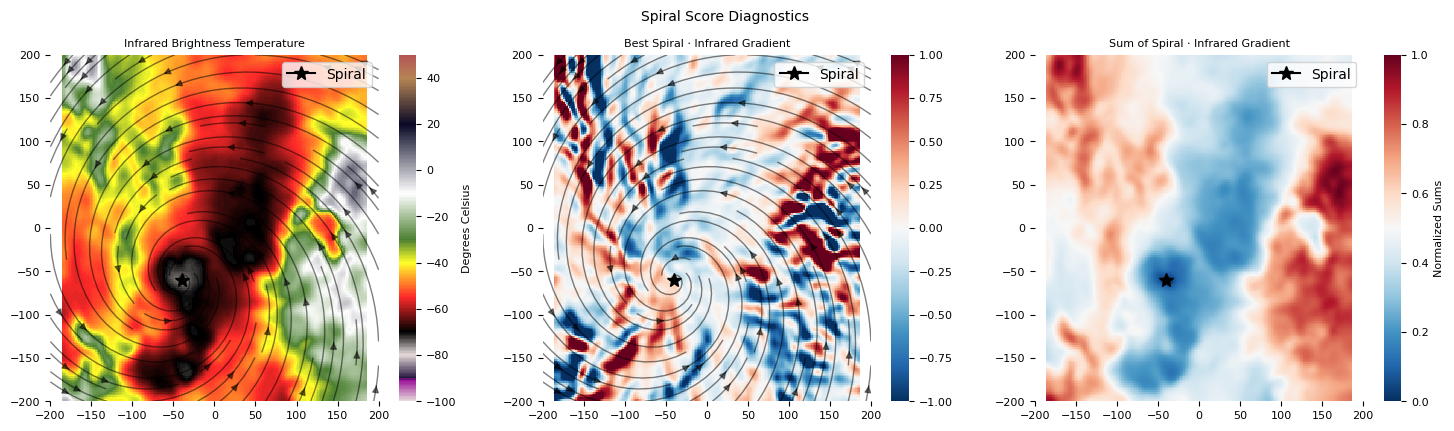

22.1 -76.5
(201, 201) (201, 201) (201, 201)
Best:  62.000000000000234 194.00000000000034 13740.046130211318
(40401,) (201, 201)
(201, 201)


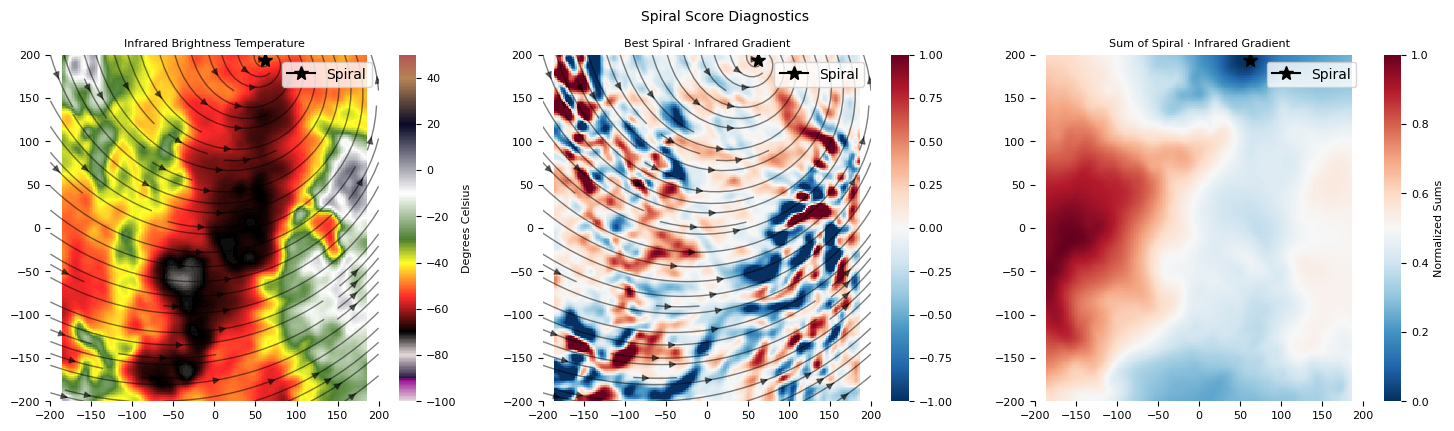

In [58]:
satt = '19'
year = 2025
month = 9
day = 27
time = '2130'
loc = (22.1, -76.5)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)

GOES-19 data downloaded for 9/27/2025 at 2130z
23 -61


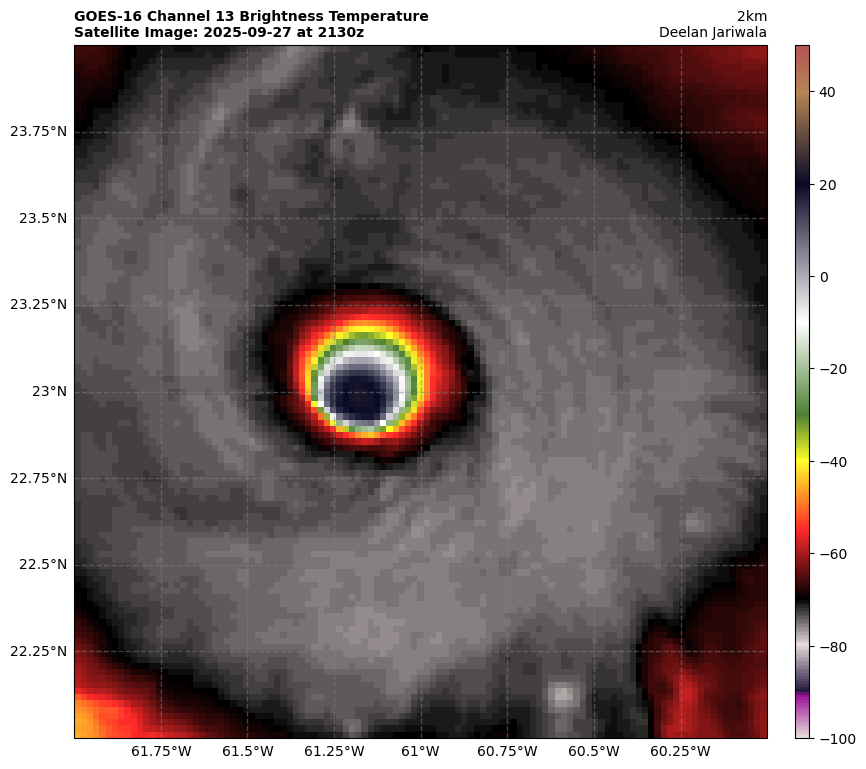

Dimensions = 2
current iteration is: 0
current iteration is: 1
current iteration is: 2
ir_rad_dif: 94.46
ir_grad: 1.91
curr_std: 3.80
eye_score: 13.21
Done.
New Coordinates:  23.017698500000183 -61.16228649999914
23.017698500000183 -61.16228649999914
171
CDO STD: 0.5329679828287658 1.87628531585036
Eye Temp:  22.007186415188237 C
Min CDO Temp:  -72.16324355252097 C


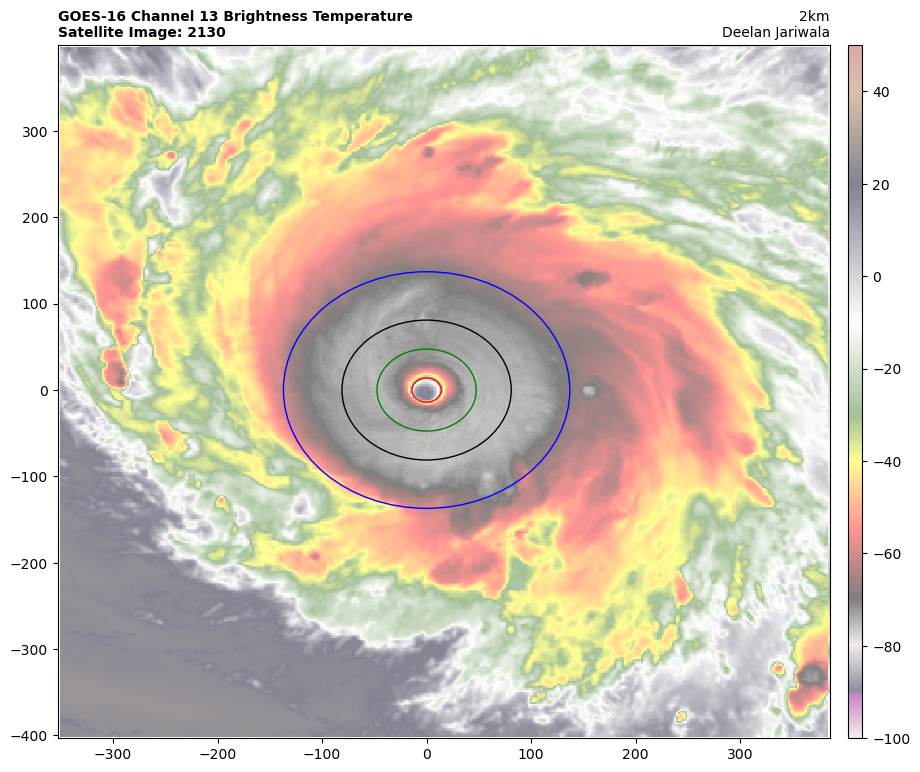

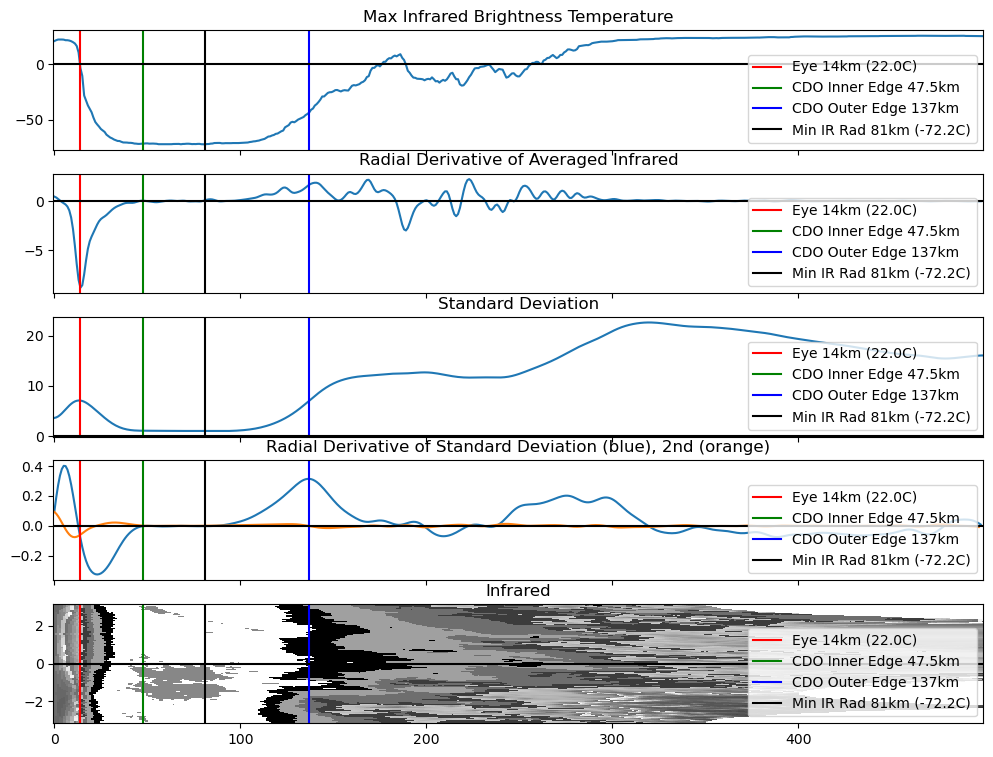

CDO Radius:  123
[np.int64(123), np.float64(1.87628531585036), np.int64(14), np.float64(22.007186415188237), np.float64(-72.16324355252097), np.int64(81), np.float64(23.017698500000183)]


In [59]:
satt = '19'
year = 2025
month = 9
day = 27
time = '2130'
loc = (23, -61)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)

GOES-19 data downloaded for 9/27/2025 at 2040z
23 -61


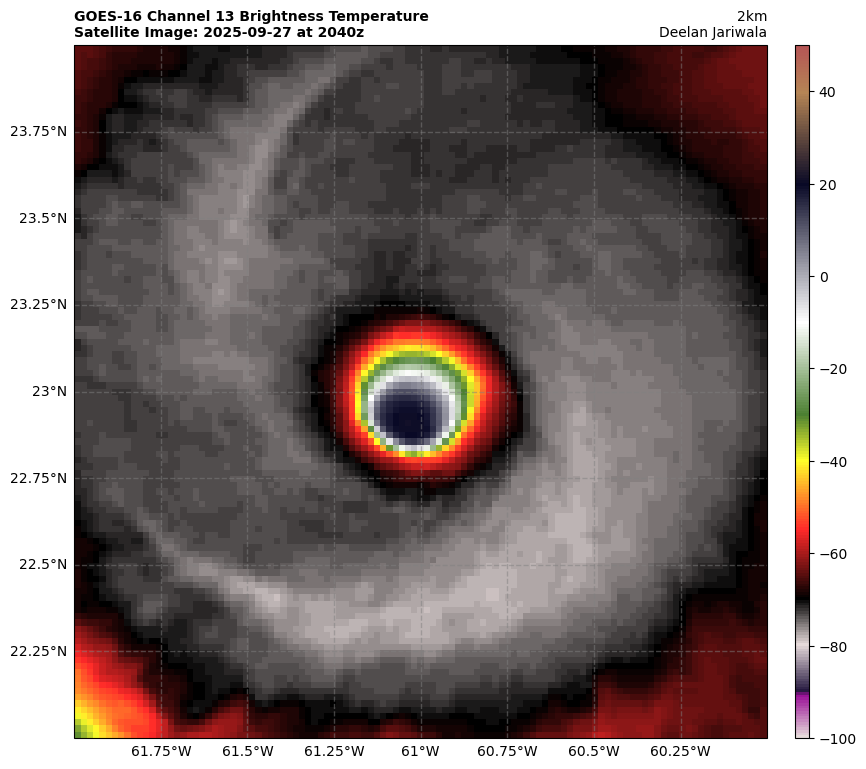

Dimensions = 2
current iteration is: 0
current iteration is: 1
ir_rad_dif: 92.10
ir_grad: 1.79
curr_std: 3.78
eye_score: 12.51
Done.
New Coordinates:  22.96370300000018 -61.018298499999105
22.96370300000018 -61.018298499999105
229
CDO STD: 0.4396436821303893 2.274569249248123
Eye Temp:  20.750268259080293 C
Min CDO Temp:  -72.62930338699587 C


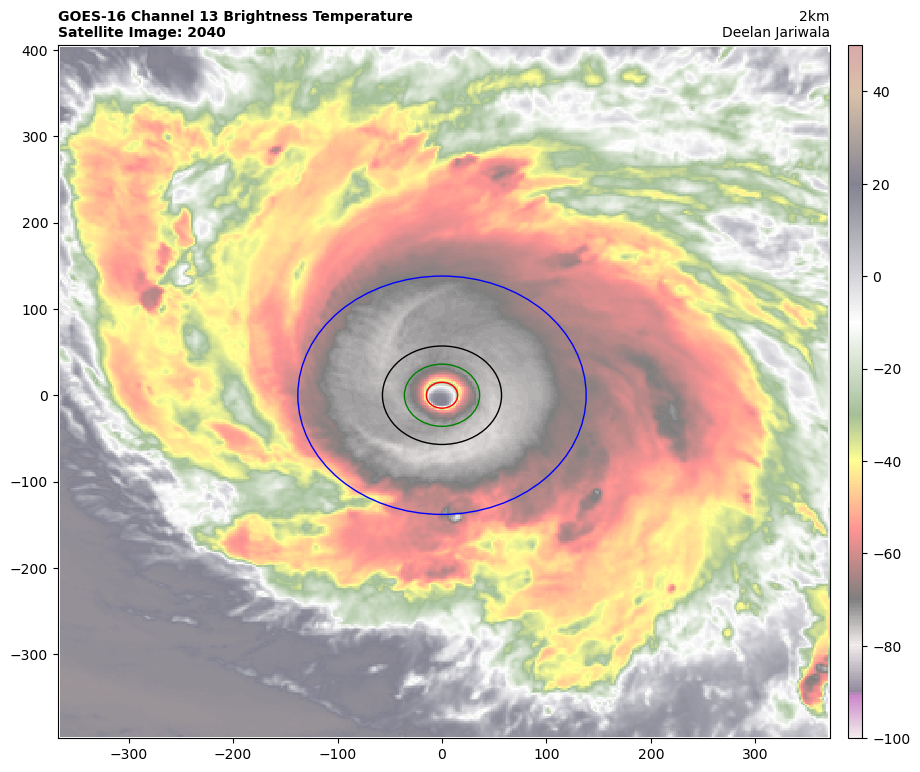

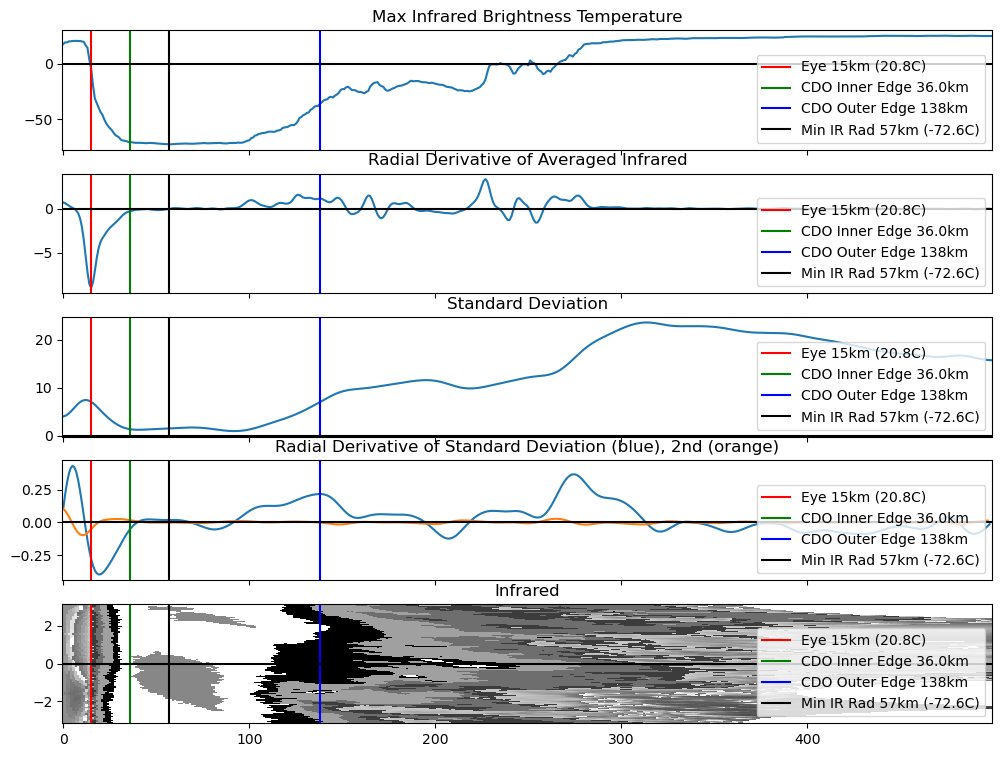

CDO Radius:  123
[np.int64(123), np.float64(2.274569249248123), np.int64(15), np.float64(20.750268259080293), np.float64(-72.62930338699587), np.int64(57), np.float64(22.96370300000018)]


In [60]:
satt = '19'
year = 2025
month = 9
day = 27
time = '2040'
loc = (23, -61)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)

GOES-19 data downloaded for 9/29/2025 at 0200z
26 -66


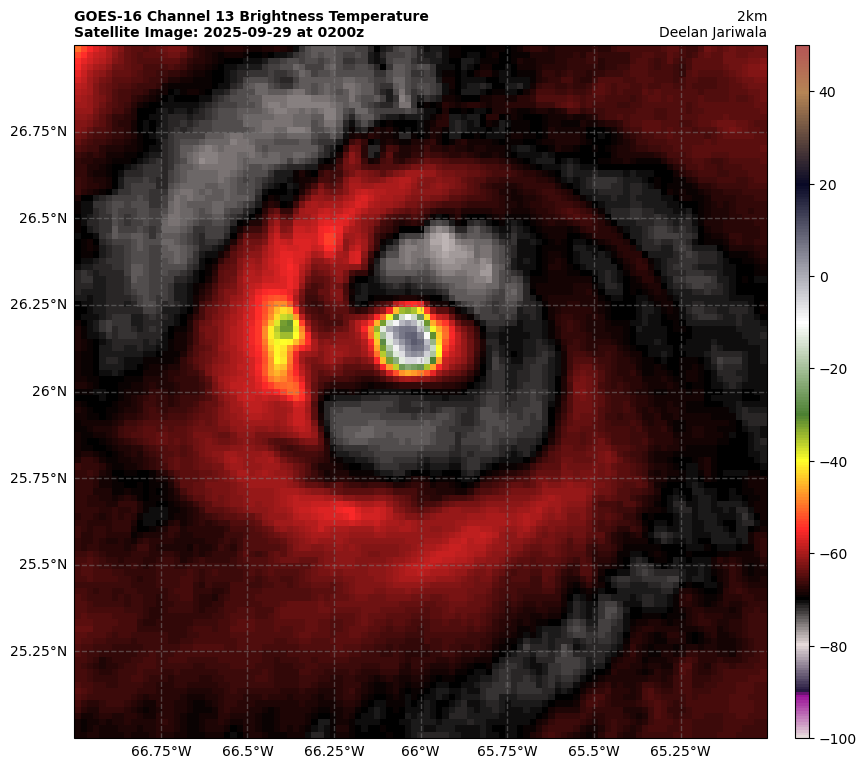

Dimensions = 2
current iteration is: 0
current iteration is: 1
current iteration is: 2
ir_rad_dif: 76.97
ir_grad: 2.78
curr_std: 5.77
eye_score: 8.36
Done.
New Coordinates:  26.14368800000019 -66.03629699999911
26.14368800000019 -66.03629699999911
198
CDO STD: 0.1807644184903094 5.532062163293541
Eye Temp:  9.675962959914042 C
Min CDO Temp:  -64.65605182124652 C


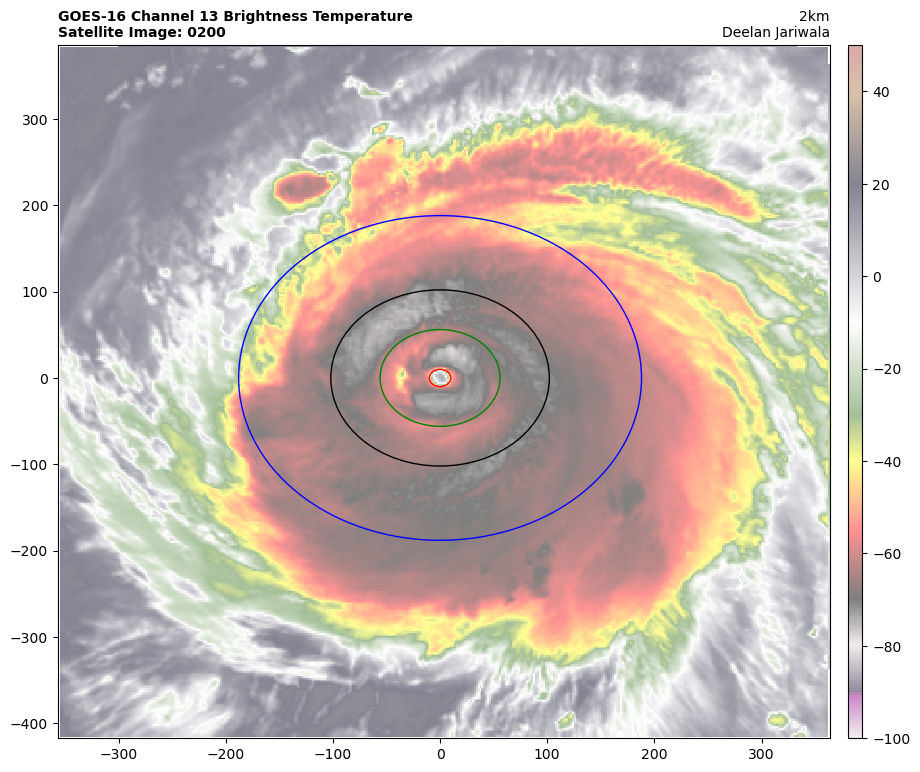

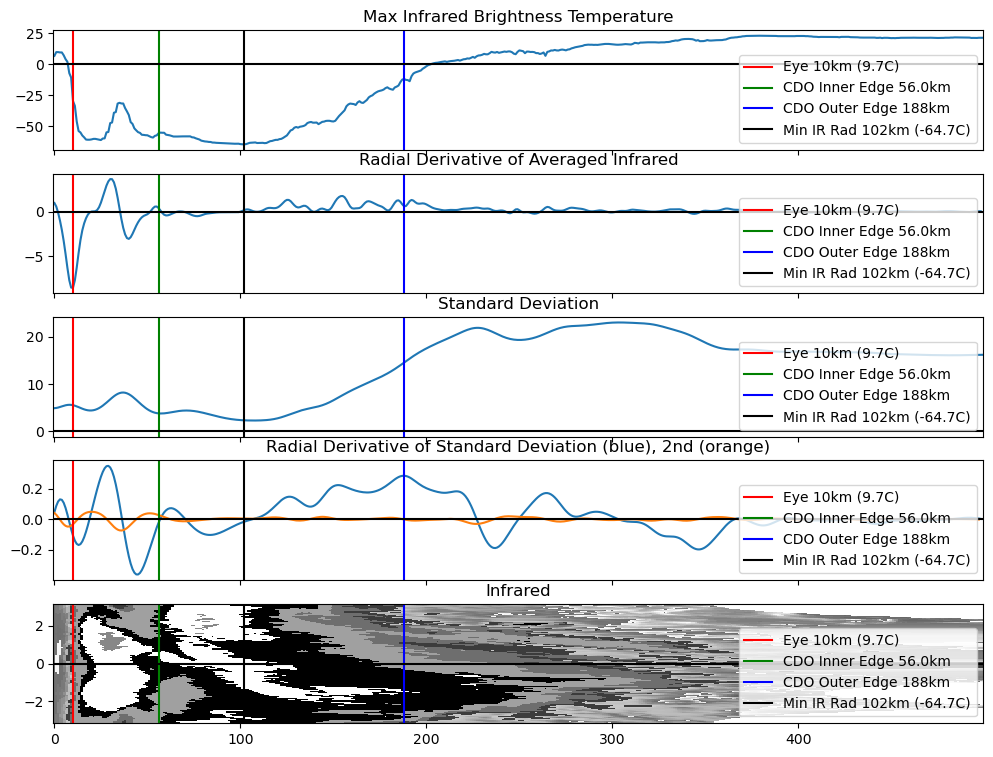

CDO Radius:  178
[np.int64(178), np.float64(5.532062163293541), np.int64(10), np.float64(9.675962959914042), np.float64(-64.65605182124652), np.int64(102), np.float64(26.14368800000019)]
120.36461650285216


In [53]:
satt = '19'
year = 2025
month = 9
day = 29
time = '0200'
loc = (26, -66)
data = getStormParams(satt, year, month, day, time, loc, locType = 'best')
print(data)
print(intensityGuess(data))

GOES-19 data downloaded for 9/29/2025 at 2350z
28 -77.3
(201, 201) (201, 201) (201, 201)
0.5797177479685611
Best:  86.00000000000026 102.00000000000027 0.0
(40401,) (201, 201)
(201, 201)


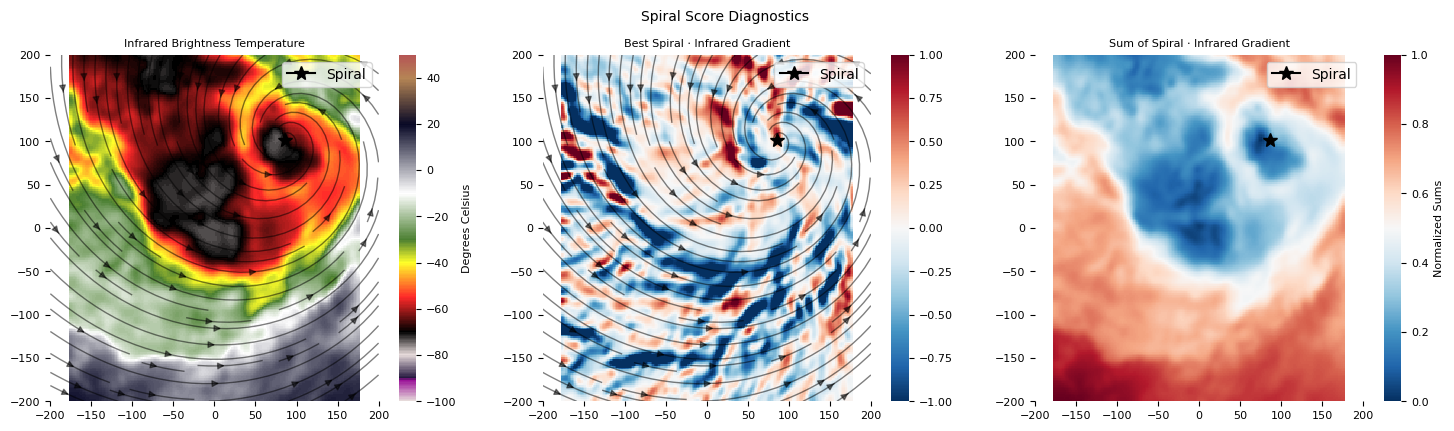

28 -77.3
(201, 201) (201, 201) (201, 201)
Best:  200.00000000000034 -135.99999999999994 12381.980430521744
(40401,) (201, 201)
(201, 201)


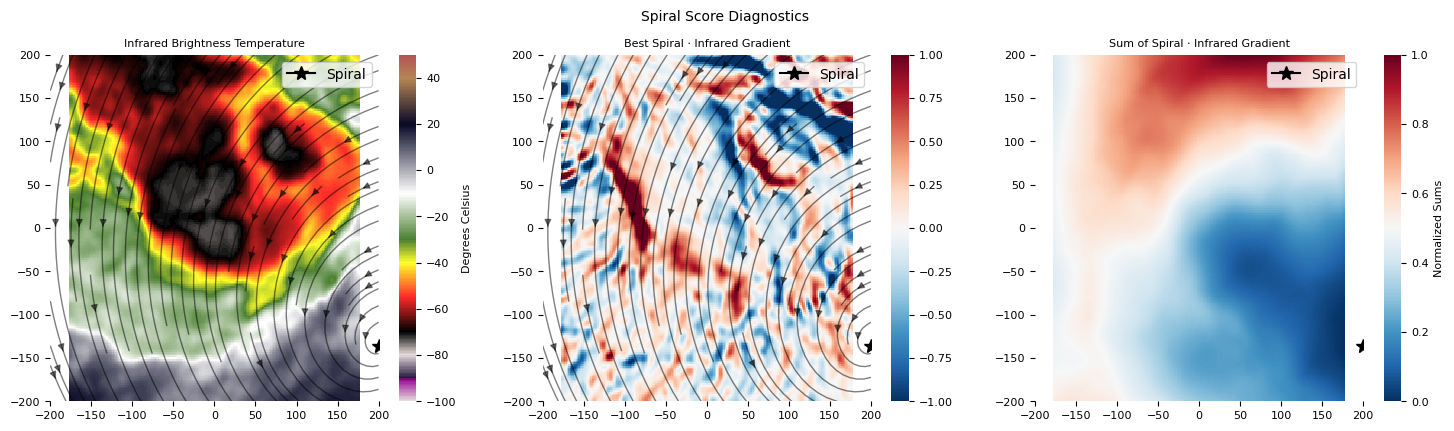

In [57]:
satt = '19'
year = 2025
month = 9
day = 29
time = '2350'
loc = (28, -77.3)
filename = img.getDataGOES(satt, year, month, day, time, '13')
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\\" + filename + ".nc")
allLats, allLons = calculate_degrees(dataset)
lons, lats, data = reproject(dataset, allLats, allLons, loc)
getSpiralScore(lats, lons, data, loc, weight = True)
getSpiralScore(lats, lons, data, loc)